In [1]:
import os
os.chdir("../")

import semiolog as slg

In [2]:
semiotic = slg.Cenematic("en_bnc")

SLG [I]: Checking config correctness... Config correct!


100%|██████████| 3/3 [00:00<00:00, 26.51it/s]

SLG [I]: Dataset loaded from disk (TXT files)
SLG [I]: Vocabulary loaded from disk


SLG [I]: nGrams loaded from disk (['6.json', '7.json', '2.json', '3.json', '4.json', '5.json'])
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-04-25 22:39:26.657405: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-25 22:39:26.657655: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at models/en_bnc/paradigms/tf_model.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


SLG [I]: Paradigmatizer loaded from disk


In [3]:
from collections import defaultdict
import seaborn as sns
import networkx as nx
import graphviz as gv
from ipywidgets import interact
from math import log
from numpy.linalg import svd
import numpy as np

In [4]:
def norm_pmi_dict(a:dict, ab:dict):
    #TODO this needs to be revised, in particular for the "\\"
    norm_factor = 1/sum(a.values())
    a_norm = {k:v*norm_factor for k,v in a.items()}
    ab_norm = {k:v*norm_factor for k,v in ab.items()}

    ab_norm_pmi = defaultdict(lambda: -1)
    for k,v in ab_norm.items():
        if '\\' not in k:
            ab_norm_pmi[k] = log(v/(a_norm[k[0]]*a_norm[k[1]]))*-1/log(v)

    # ab_norm_pmi = {k:log(v/(a_norm[k[0]]*a_norm[k[1]]))*1/log(v) for k,v in ab_norm.items() if '\\' not in k}

    return ab_norm_pmi

In [5]:
ng1 = semiotic.vocab.ng1
ng2 = semiotic.vocab.ng2
ng3 = semiotic.vocab.ng3
ng4 = semiotic.vocab.ng4
ng5 = semiotic.vocab.ng5
ng6 = semiotic.vocab.ng6
ng7 = semiotic.vocab.ng7

In [5]:
ng1keys = semiotic.vocab.ng1.keys[:37]
ng1freq = semiotic.vocab.ng1.freq
ng1_enc = semiotic.vocab.ng1.encode
ng1_dec = semiotic.vocab.ng1.decode
ng2keys = [l+r for l in ng1keys for r in ng1keys]
ng2_enc = {k: i for i,k in enumerate(ng2keys)}
ng2_dec = {i: k for i,k in enumerate(ng2keys)}
ng1 = semiotic.vocab.ng1
ng2 = semiotic.vocab.ng2
ng3 = semiotic.vocab.ng3

ng2_norm_pmi = norm_pmi_dict(ng1.freq, ng2.freq)

In [5]:
m_freq_1_1 = slg.util.build_term_context_matrix(
    terms = ng1keys,
    contexts = ng1keys,
    orthogonals = ng2.freq,
    normalizeQ = False)
    
m_freq_2_1 = slg.util.build_term_context_matrix(
    terms = ng2keys,
    contexts = ng1keys,
    orthogonals = ng3.freq,
    normalizeQ = False)

m_freq_1_2 = slg.util.build_term_context_matrix(
    terms = ng1keys,
    contexts = ng2keys,
    orthogonals = ng3.freq,
    normalizeQ = False)

Building oR Matrix...
Term-Context Matrix built in 0.0 secs.

Building oR Matrix...
Term-Context Matrix built in 0.28 secs.

Building oR Matrix...
Term-Context Matrix built in 0.02 secs.



In [6]:
m_pmi_1_1 = slg.util.build_pmi_matrix(
    m_freq_1_1,
    type = "spmi",
    alpha = .75,
    normalizeQ = False,
    )
m_pmi_2_1 = slg.util.build_pmi_matrix(
    m_freq_2_1,
    type = "spmi",
    alpha = .75,
    normalizeQ = False,
    )
m_pmi_1_2 = slg.util.build_pmi_matrix(
    m_freq_1_2,
    type = "spmi",
    alpha = .75,
    normalizeQ = False,
    )

Computing PMI Matrix...
Type: spmi
Smoothing (alpha): 0.75
Done
PMI Matrix built in 0.03 secs.
Done

Computing PMI Matrix...
Type: spmi
Smoothing (alpha): 0.75
Done
PMI Matrix built in 0.77 secs.
Done

Computing PMI Matrix...
Type: spmi
Smoothing (alpha): 0.75
Done
PMI Matrix built in 0.78 secs.
Done



In [7]:
m_norm_pmi_1_1 = slg.util.build_term_context_matrix(
    terms = ng1keys,
    contexts = ng1keys,
    orthogonals = ng2_norm_pmi,
    normalizeQ = False)

Building oR Matrix...
Term-Context Matrix built in 0.01 secs.



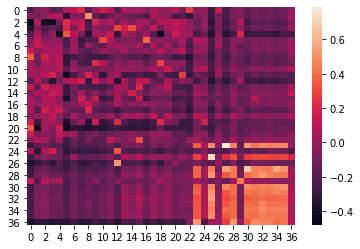

In [8]:
ax = sns.heatmap(m_norm_pmi_1_1.toarray())

In [8]:
U11, s11, Vh11 = svd11 = svd(m_pmi_1_1.toarray())
U21, s21, Vh21 = svd21 = svd(m_pmi_2_1.toarray())
U12, s12, Vh12 = svd12 = svd(m_pmi_1_2.toarray())

In [9]:
U11, s11, Vh11 = svd11 = svd(m_norm_pmi_1_1.toarray())

In [10]:
Tn = 0
T_sign = -1
U = U11
Vh = Vh11

type_L = sorted([(score*T_sign,term) for term, score in zip(ng1keys,U.T[Tn])], reverse=True)
type_R = sorted([(score*T_sign,context) for context, score in zip(ng1keys,Vh[Tn])], reverse=True)
slg.util.df([type_L[:15],type_R[:15]])

,0,1
0,"(0.3284938221771163, 1)","(0.3496899236221681, 0)"
1,"(0.32597298347372805, 9)","(0.31232626236083033, 8)"
2,"(0.2946954550710602, 8)","(0.3099012819651378, 5)"
3,"(0.289136814374553, £)","(0.30819761873749923, 9)"
4,"(0.28311291829309304, 2)","(0.30581311256527033, 7)"
5,"(0.27610544125336456, 7)","(0.2961987547861401, 6)"
6,"(0.27562053043779094, 3)","(0.28891767227786336, 4)"
7,"(0.26321254421318546, 6)","(0.28305635041447874, 3)"
8,"(0.2600356988533819, 4)","(0.2732544547961956, 2)"
9,"(0.2504448675507056, 5)","(0.24309146789874217, 1)"


In [13]:
from random import randint
sent = semiotic.corpus.train[randint(0,100000)]["text"]
# sent = "This is very good"
sent = "understanding"
norm_text = semiotic.syntagmatic.tokenizer.normalizer.normalize_str(sent)
sent

'understanding'

In [14]:
pairs = set(slg.vocabulary.nGram.extract_ngrams(norm_text,2))
triplets = set(slg.vocabulary.nGram.extract_ngrams(norm_text,3))
triplets21 = {("".join((l,c)),r) for l,c,r in triplets}
triplets12 = {(l,"".join((c,r))) for l,c,r in triplets}


In [15]:
def tuple_scores(tuples,svd,ng_l,ng_r):
    U,s,Vh = svd
    tup_scores = []
    for tup in tuples:
        l = tup[0]
        r = tup[1]

        Tn_scores = []
        for type_n in range(s.size):
            Tl_score = U.T[type_n,ng_l[l]]
            Tr_score = Vh[type_n,ng_r[r]]
            Tn_score = Tl_score*Tr_score*s[type_n]
            signature = 1 if Tl_score>=0 else -1
            Tn_scores.append((Tn_score, type_n, signature))

        Tn_scores = sorted(Tn_scores,reverse=True)
        
        tup_scores.append((tup,Tn_scores[0]))

    tup_scores_dict = dict(tup_scores)

    segmentation_index = defaultdict(list)
    for i, tup in enumerate(zip(norm_text, norm_text[1:])):
        segmentation_index[tup] += [i+1]
        
    tup_scores_sorted = sorted(tup_scores,key=lambda x: x[1][0])
    return tup_scores_sorted

In [16]:
norm_pmi = {k:v for k,(v,t,s) in tuple_scores(pairs,svd11,ng1_enc,ng1_enc)}

In [17]:
G = nx.DiGraph()

to_segment = [(norm_text,(0,len(norm_text)))]

while len(to_segment)>0:
    for segment, offset in to_segment:
        segmentation_index = defaultdict(list)
        pairs = []
        for i, pair in enumerate(zip(segment, segment[1:])):
            segmentation_index[pair] += [i+1]
            pairs.append(pair)
        best_pair = sorted([(norm_pmi[pair], pair) for pair in pairs])[0][1]
        best_cut = segmentation_index[best_pair][0]
        G.add_edge((segment,offset), (segment[:best_cut],(offset[0],offset[0]+best_cut)))
        G.add_edge((segment,offset), (segment[best_cut:],(offset[0]+best_cut,offset[1])))
        
        to_segment = [x for x in G.nodes() if G.out_degree(x)==0 and G.in_degree(x)==1]
        to_segment = [seg for seg in to_segment if len(seg[0])>2]

In [18]:
seg_tree = G
seg_tree_graph = gv.Digraph(name="seg_tree")

tree_nodes_list = [(str(i), l) for l, i in list(seg_tree.nodes)]
for node in tree_nodes_list:
    seg_tree_graph.node(
        *node, color="white", fontsize="20", fontname="RobotoMono-Thin"
    )  # style="filled", color="grey")
seg_tree_graph.attr("edge", color="slategrey")
seg_tree_graph.edges([(str(p[1]), str(c[1])) for p, c in list(seg_tree.edges)])

@interact
def inter():
    return seg_tree_graph

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [6]:
ng1.freq
norm_factor = 1/sum(ng1.freq.values())

ng1.prob = {k:v*norm_factor for k,v in ng1.freq.items()}
ng2.prob = {k:v*norm_factor for k,v in ng2.freq.items()}
ng3.prob = {k:v*norm_factor for k,v in ng3.freq.items()}

ng_prob = {**ng1.prob,**ng2.prob,**ng3.prob}

In [7]:
def pmi(prob_a,prob_b,prob_ab):
    return log(prob_ab/(prob_a*prob_b))*-1/log(prob_ab)

In [8]:
pmi(ng_prob["th"],ng_prob["e"],ng_prob["the"])

0.4208809512081089

In [9]:
sorted([()])
print([k for v,k in sorted([(-v,k) for k,v in ng_prob.items()])][:500])

['e', 't', 'a', 'o', 'i', 'n', 's', 'r', 'h', 'l', 'd', 'c', 'th', 'u', 'm', 'he', 'f', 'p', 'g', 'w', 'in', 'the', 'y', 'er', 'b', 'an', 're', 'on', 'es', 'nt', 'en', 'st', 'at', 'ti', 'ed', 'nd', 'to', 'v', 'or', 'ea', 'ha', 'it', 'te', 'ar', 'ou', 'ng', 'is', 'al', 'as', 'of', 'et', 'se', 'k', 'and', 'ing', 've', 'le', 'ro', 'hi', 'me', 'co', 'sa', 'ra', 'ne', 'ec', 'ta', 'ri', 'de', 'si', 'so', 'el', 'll', 'li', 'io', 'ic', 'di', 'no', 'be', 'ot', 'tt', 'om', 'ce', 'rt', 'la', 'ee', 'ma', 'ch', 'na', 'ent', 'em', 'ns', 'ion', 'ho', 'ur', 'her', 'ss', 'ts', 'rs', 'ca', 'fo', 'wa', 'sh', 'ac', 'ni', 'ere', 'ei', 'tha', 'il', 'ut', 'dt', 'pe', 'ly', 'us', 'nc', 'da', 'lo', 'tr', 'ew', 'tio', 'we', 'eo', 'ad', 'wh', 'ow', 'ep', 'wi', 'pr', 'un', 'ge', 'ft', 'for', 'hat', 'do', 'nth', 'ct', 'int', 'ai', 'ef', 'ati', 'yo', 'os', 'ol', 'id', 'ie', 'ul', 'mo', 'po', 'pa', 'ter', 'mi', 'fi', 'ld', 'eth', 'im', 'ir', 'su', 'est', 'am', 'gh', 'oft', 'ds', 'ke', 'ev', 'oo', 'hes', 'tw', 'fth',

In [12]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [78]:
sent = "idontknow"
len_sent = len(sent)
pws = list(powerset(range(len_sent+1)))
possible_cuts = [i for i in pws if 0 in i and len_sent in i]
possible_offsets = []
for cut in possible_cuts:
    possible_offsets.append(list(zip(cut,cut[1:])))
possible_offsets_3 = []
for offset in possible_offsets:
    if max([r-l for l,r in offset])<4:
        possible_offsets_3.append(offset)
seg_probs = []
for offsets in possible_offsets_3:
    segs = [sent[l:r] for l,r in offsets]
    seg_probs.append((np.prod([ng_prob[seg] for seg in segs]), segs))

sorted(seg_probs, reverse=True)[:10]

[(4.903867366027767e-11, ['id', 'ont', 'kno', 'w']),
 (4.76842250274295e-11, ['i', 'don', 't', 'kno', 'w']),
 (4.6859339693523e-11, ['i', 'd', 'ont', 'kno', 'w']),
 (3.18650729523893e-11, ['id', 'ont', 'k', 'now']),
 (3.098495933441168e-11, ['i', 'don', 't', 'k', 'now']),
 (3.0448953170697307e-11, ['i', 'd', 'ont', 'k', 'now']),
 (2.8792374341417805e-11, ['id', 'on', 't', 'kno', 'w']),
 (2.7512808751604654e-11, ['i', 'd', 'on', 't', 'kno', 'w']),
 (2.2840795545803972e-11, ['i', 'do', 'nt', 'kno', 'w']),
 (2.2000307192469672e-11, ['id', 'o', 'nt', 'kno', 'w'])]

In [19]:
leaves = sorted([x for x in G.nodes() if G.out_degree(x)==0 and G.in_degree(x)==1],key=lambda x:x[1])
[k for k,o in leaves]

['un', 'd', 'er', 's', 't', 'an', 'd', 'in', 'g']

In [ ]:
types = defaultdict(list)
for pair, (score,type,sig) in pair_scores:
    types[(type,sig)] += [pair]

In [ ]:
m_freq_2_1 = slg.util.build_term_context_matrix(
    terms = ng1keys+ng2keys,
    contexts = ng1keys,
    orthogonals = {**ng2.freq, **ng3.freq},
    normalizeQ = False)

m_freq_1_2 = slg.util.build_term_context_matrix(
    terms = ng1keys,
    contexts = ng1keys+ng2keys,
    orthogonals = {**ng2.freq, **ng3.freq},
    normalizeQ = False)

Building oR Matrix...
Term-Context Matrix built in 0.09 secs.

Building oR Matrix...
Term-Context Matrix built in 0.03 secs.



In [ ]:
m_pmi_2_1 = slg.util.build_pmi_matrix(
    m_freq_2_1,
    type = "spmi",
    alpha = .75,
    normalizeQ = False,
    )
m_pmi_1_2 = slg.util.build_pmi_matrix(
    m_freq_1_2,
    type = "spmi",
    alpha = .75,
    normalizeQ = False,
    )

Computing PMI Matrix...
Type: spmi
Smoothing (alpha): 0.75
Done
PMI Matrix built in 0.96 secs.
Done

Computing PMI Matrix...
Type: spmi
Smoothing (alpha): 0.75
Done
PMI Matrix built in 0.9 secs.
Done



In [ ]:
U21, s21, Vh21 = svd21 = svd(m_pmi_2_1.toarray())
U12, s12, Vh12 = svd12 = svd(m_pmi_1_2.toarray())

In [22]:
all_types = []
columns = []
for Tn in range(5):
    for T_sign in [1,-1]:
        U = U12
        Vh = Vh12

        keys_left = ng1keys
        keys_right = ng1keys+ng2keys
        i = 0
        j = 30

        type_L = sorted([(score*T_sign,term) for term, score in zip(keys_left,U.T[Tn])], reverse=True)
        type_R = sorted([(score*T_sign,context) for context, score in zip(keys_right,Vh[Tn])], reverse=True)

        all_types.extend([[k for v,k in type_L[:7]],[k for v,k in type_R[:7]]])
        columns.extend([f"{str(T_sign).replace('1','')}{Tn}_l",f"{str(T_sign).replace('1','')}{Tn}_r"])

slg.util.df(all_types,columns)

,0_l,0_r,-0_l,-0_r,1_l,1_r,-1_l,-1_r,2_l,2_r,-2_l,-2_r,3_l,3_r,-3_l,-3_r,4_l,4_r,-4_l,-4_r
0,£,gn,h,tn,a,id,1,js,t,oo,i,dk,v,m£,e,75,q,gn,u,jg
1,7,jp,t,on,o,et,9,jp,s,e,u,id,j,jh,n,30,o,ci,i,d
2,6,ja,w,s,i,it,8,jm,g,ao,a,hk,q,jl,r,eh,£,ce,w,e
3,4,sk,v,6z,e,hl,2,j0,c,y,o,ik,z,jk,s,mu,a,ca,k,au
4,5,ji,b,6q,r,hd,7,ja,d,oe,e,2z,b,jc,y,40,e,gc,0,a
5,2,jf,c,tr,l,is,3,jt,h,o,q,ig,w,pz,a,70,9,co,y,r
6,8,q8,p,6j,u,ig,6,jh,b,am,1,mf,k,sq,d,fe,j,gd,g,tl


In [ ]:
enc3 = {k:i for i,k in enumerate(ng1keys+ng2keys)}

In [ ]:
tuple_scores([("t","he")],svd12,ng1_enc,enc3)

In [ ]:
tuple_scores([("th","e")],svd21,enc3,ng1_enc)

[(('th', 'e'), (0.3849925595943337, 19, -1))]